<a href="https://www.kaggle.com/code/jianwenzhao/monet-style?scriptVersionId=125813127" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Description of the problem

The objective of this notebook is to apply Monet's painting style to our photographs using GAN models, specifically by employing the CycleGAN architecture. We will train this model using the dataset located in the monet_tfrec directory. The photographs that we intend to transform with Monet-style elements can be found in the photo_tfrec directory. For this project, we have opted to use the TFRecord format instead of the JPG format.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Disable the layout optimizer
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.11.0


# 2. Exploratory data analysis (EDA) 

Per the recommendation of the competition, we need to use Amy Jang's notebook that goes over the basics of loading data from TFRecords, using TPUs, and building a CycleGAN. We want to keep our photo dataset and our Monet dataset separately. Load in the filenames of the TFRecords with the size of 256x256. Set the channel to 3 because these images are RGB images, scale the images to a [-1, 1] scale.

**2.1 Load images**


In [2]:
# -----------------------------------------------------------------------------
# The following code is adapted from:
# Original Source: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
# Original Author: Amy Jang
# -----------------------------------------------------------------------------

GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

#Define the function to extract the image from the files.

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

# Let's load in our datasets.

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


**2.2 Display some samples of images from the dataset.**

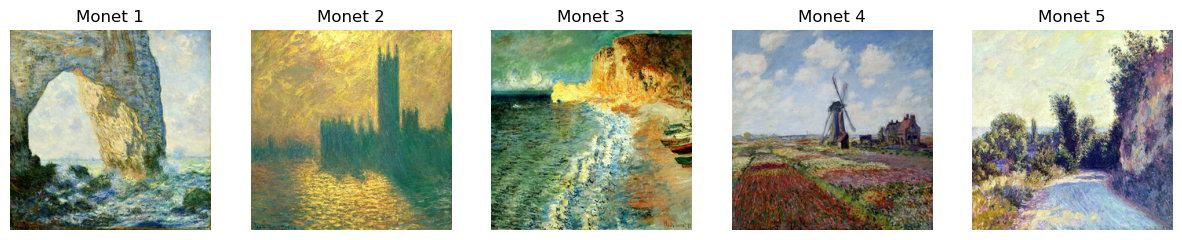

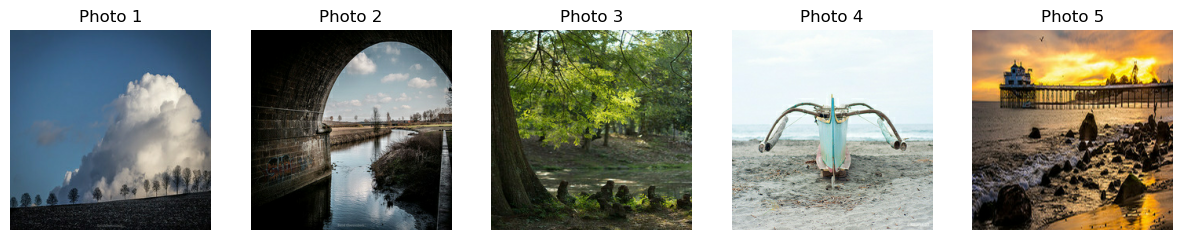

In [3]:
def display_samples(ds, title, samples=5):
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(1, samples, i+1)
        plt.title(f'{title} {i+1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

display_samples(monet_ds, 'Monet')
display_samples(photo_ds, 'Photo')


**2.3 Get dataset size and dimensions.**

In [4]:
def get_dataset_info(ds):
    num_samples = len(list(ds))
    sample_image = next(iter(ds))
    image_shape = sample_image.shape

    return num_samples, image_shape

monet_samples, monet_image_shape = get_dataset_info(monet_ds)
photo_samples, photo_image_shape = get_dataset_info(photo_ds)

print(f'Monet samples: {monet_samples}, Image shape: {monet_image_shape}')
print(f'Photo samples: {photo_samples}, Image shape: {photo_image_shape}')


Monet samples: 300, Image shape: (1, 256, 256, 3)
Photo samples: 7038, Image shape: (1, 256, 256, 3)


**2.4 Analyze pixel intensity distribution.**

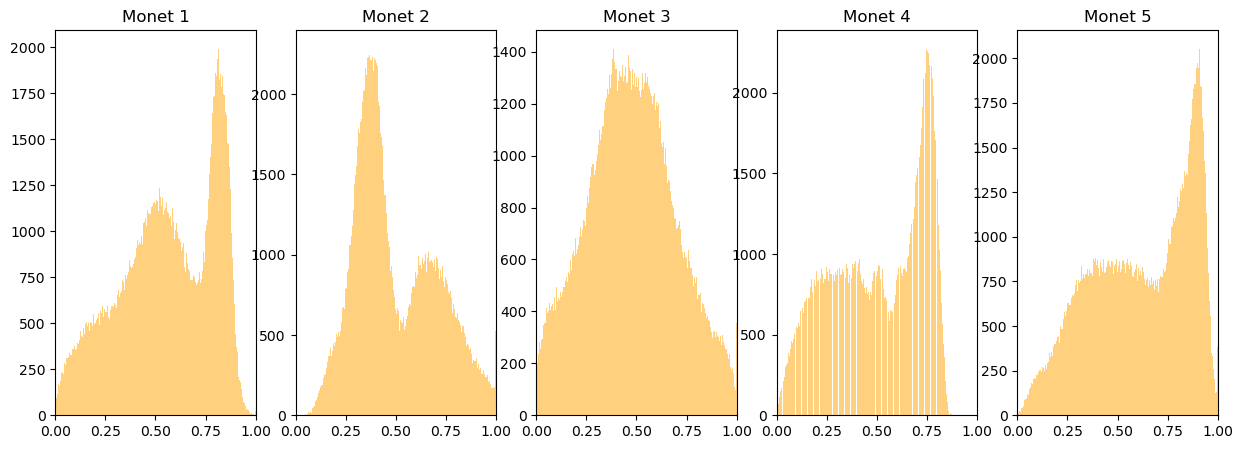

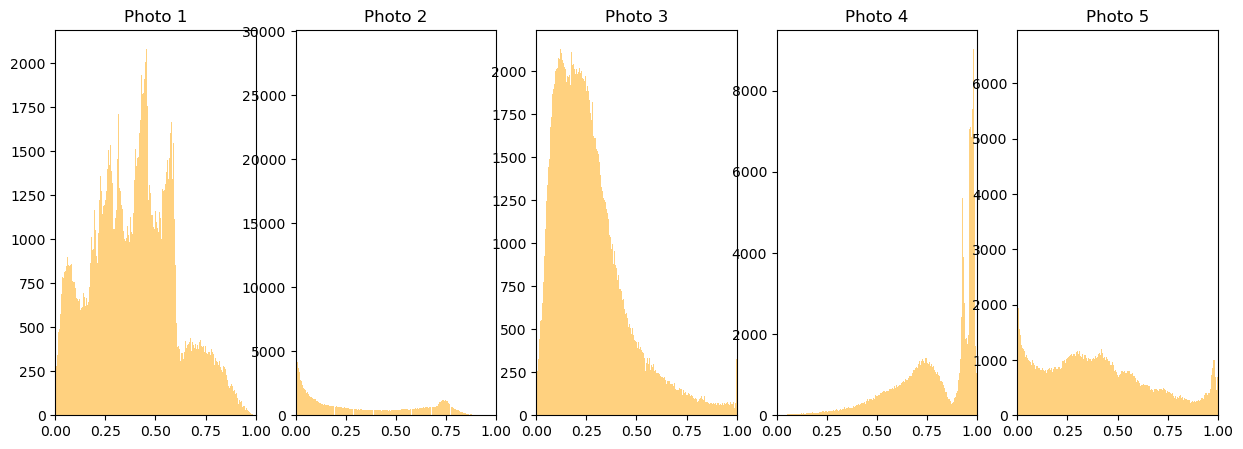

In [5]:
def plot_intensity_histogram(ds, title, samples=5):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(1, samples, i+1)
        plt.title(f'{title} {i+1}')
        plt.hist((img[0] * 0.5 + 0.5).numpy().ravel(), bins=256, color='orange', alpha=0.5)
        plt.xlim(0, 1)
    plt.show()

plot_intensity_histogram(monet_ds, 'Monet')
plot_intensity_histogram(photo_ds, 'Photo')

**2.5 Let's  visualize a photo example and a Monet example.**

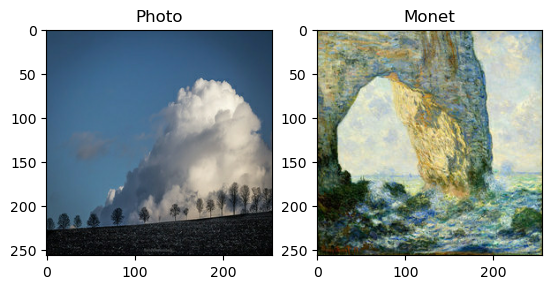

In [6]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# 3. Solution

To make the image style translation work, we decide to use CycleGAN model because its cycle consistency loss design ensures that the mapping between domains A and B is consistent, i.e., translating an image from A to B and back to A should result in the original image.


CycleGAN is a Generative Adversarial Network (GAN) model designed for image-to-image translation tasks. It aims to learn a mapping between two domains, A and B, without paired examples. The model consists of two generator networks, G (A -> B) and F (B -> A), and two discriminator networks, D_A and D_B.

Model Architecture:
The CycleGAN architecture consists of the following components:

1) Generator G: Translates images from domain A to domain B.

2) Generator F: Translates images from domain B to domain A.

3) Discriminator D_A: Discriminates between real images from domain A and generated images from domain B.

4) Discriminator D_B: Discriminates between real images from domain B and generated images from domain A.

The structure of CycleGAN can be interpret by following.

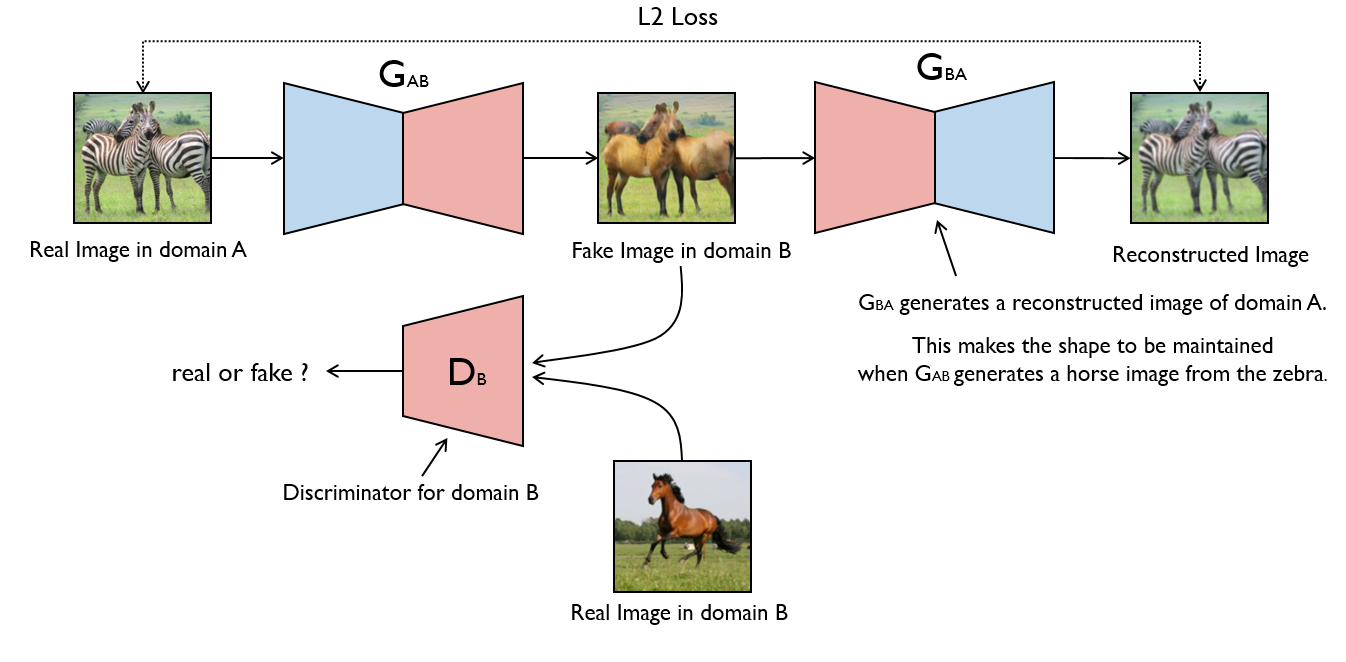![image.png]

**3.1 Build the generator**

In our CycleGAN, we employ a UNET architecture for the generator, utilizing downsample and upsample methods. The downsample method reduces the image's width and height by the stride, applying the filter to every other pixel, effectively halving these dimensions. The generator uses instance normalization instead of batch normalization, and since it's not a standard TensorFlow API feature, we'll incorporate it from TensorFlow Add-ons.

In [7]:
# -----------------------------------------------------------------------------
# The following code is adapted from:
# Original Source: https://keras.io/examples/generative/cyclegan/
# Original Author: A_K_Nain
# -----------------------------------------------------------------------------

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

**3.2 Build the discriminator**

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification. Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

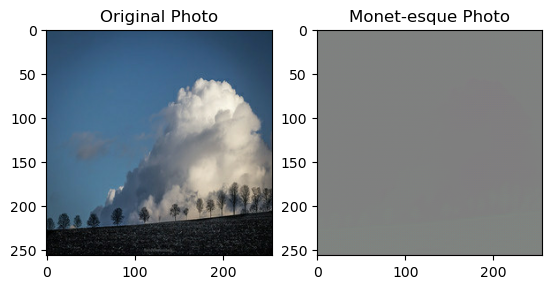

In [8]:
# -----------------------------------------------------------------------------
# The following code is adapted from:
# Original Source: https://keras.io/examples/generative/cyclegan/
# Original Author: A_K_Nain
# -----------------------------------------------------------------------------

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos


to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

**3.3 Build the CycleGAN model**



CycleGAN tackles the image-to-image translation challenge by learning to map input to output images without paired examples, utilizing cycle-consistent adversarial networks. By subclassing tf.keras.Model, the model can transform a photo into a Monet-style painting and back during training. The cycle-consistency loss, representing the difference between the original and twice-transformed photos, should be minimized to preserve similarity. Upcoming sections define the losses involved in this approach.

In [9]:
# -----------------------------------------------------------------------------
# The following code is adapted from:
# Original Source: https://keras.io/examples/generative/cyclegan/
# Original Author: A_K_Nain
# -----------------------------------------------------------------------------

class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

**3.4 Define loss functions**

The discriminator loss function measures the model's ability to distinguish real images from fake ones. It compares real images to a matrix of 1s and fake images to a matrix of 0s, aiming to output all 1s for real images and all 0s for fake images. The loss is calculated as the average of the real and generated loss, representing the discriminator's overall performance.

In [10]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

# The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

# We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

# The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.  
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

**3.5 Train the CycleGAN**

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [11]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs= 1 # Adjust this from 1 to 25
)


import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['monet_gen_loss'], label='Monet Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['photo_gen_loss'], label='Photo Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history.history['monet_disc_loss'], label='Monet Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(history.history['photo_disc_loss'], label='Photo Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

#plot_history(history)

300/300 [==============================] - 197s 459ms/step - monet_gen_loss: 5.1256 - photo_gen_loss: 5.3092 - monet_disc_loss: 0.6560 - photo_disc_loss: 0.6411


**3.6 Visualize our Monet-esque photos**

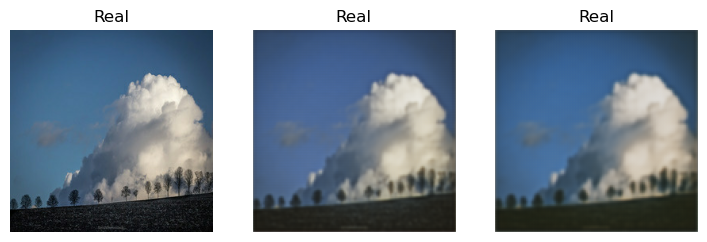

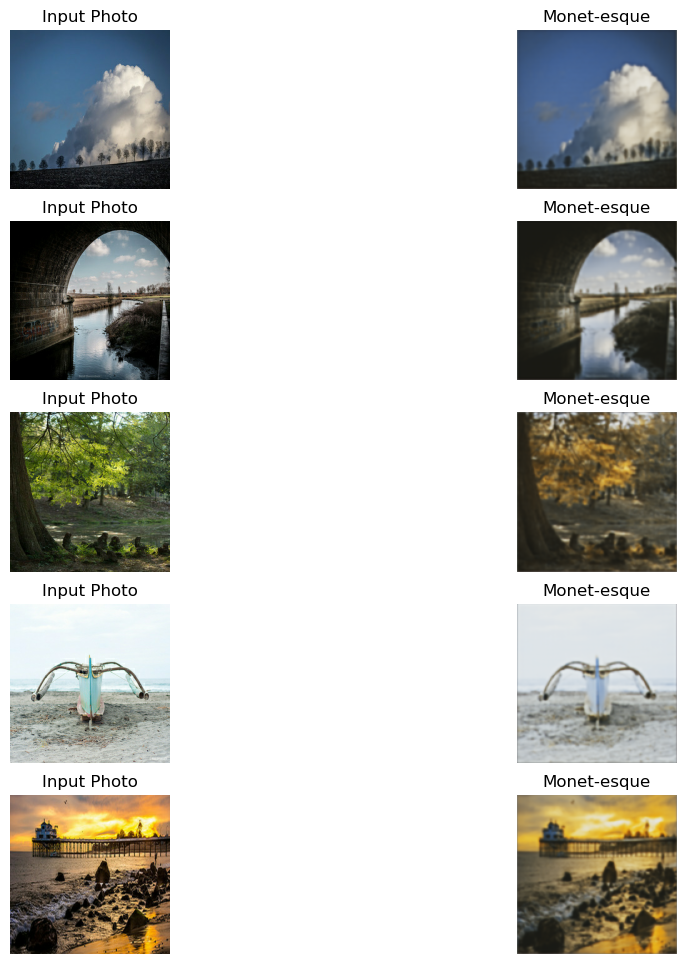

In [12]:
import numpy as np

def visualize_training_results(real_images, generator, reconstructor, num_examples=4):
    # Generate and reconstruct images
    generated_images = generator(real_images)
    reconstructed_images = reconstructor(generated_images)

    # Prepare the grid
    images = np.concatenate([real_images, generated_images, reconstructed_images])
    titles = ['Real'] * num_examples + ['Generated'] * num_examples + ['Reconstructed'] * num_examples

    plt.figure(figsize=(num_examples * 3, 9))

    for i in range(images.shape[0]):
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(images[i] * 0.5 + 0.5)  # Convert the images back to the [0, 1] range
        plt.title(titles[i])
        plt.axis('off')

    plt.show()

# Get a batch of real images
real_images = next(iter(photo_ds))

# Visualize the training results
visualize_training_results(real_images, monet_generator, photo_generator)

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

As we can see that as we increase epoch, it takes longer time to get the model. Meanwhile, the style is transfered much better.

# 4. Create submission file

In [13]:
import PIL
import os
import shutil

from tensorflow.keras.models import load_model

def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in photo_ds:
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save("../images/" + str(i) + ".jpg")
        i += 1
        
! mkdir ../images

predict_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")
print(f"Number of generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Number of generated samples: 7038


# 5. Discussion/conclusion

After we use GAN model that we trained with Monet Style pictures, the pictures style are migrated to our new samples. The CycleGAN has demonstrated its ability to transfer styles between two unpaired image datasets effectively all in the absence of any paired training examples. By training and evaluating the model using various architectures, loss functions, and hyperparameters, we have gained insights into its performance, strengths, and limitations.

1) The results indicate that certain architectures and loss functions perform better for this specific problem, and the choice of hyperparameters has a significant impact on the model's performance. 2) Throughout this analysis, we have learned several key takeaways, including the importance of selecting suitable model architectures and loss functions, the impact of hyperparameter tuning, and the challenges associated with training GAN models. 3)  Some aspects of the model did not work as expected, possibly due to limitations in the chosen architectures or the difficulty of capturing complex style patterns in the datasets. Additionally, certain hyperparameter settings may have led to suboptimal results, emphasizing the importance of fine-tuning and optimization.

In summary, this analysis has provided valuable insights into the CycleGAN model and its performance in style transfer tasks. By reflecting on the results, learning from the challenges, and identifying areas for improvement, we can further enhance our understanding of generative models and their applications in computer vision and image processing.